# Data_Cube_API_Demo
<hr>
# Notebook Summary

* LANDSAT 7 is used to detect changes in plant life over time.
* The data is cleaned of clouds and scanlines.

<hr>
# Algorithmic process  

* [Import dependencies and connect to the datacube](#import)
* [Choose platform and product](#plat_prod)
* [Get the maximum extents of the datacube](#extents)
* [Define extents you require that fall within the maximum extents](#define_extents) (selecting too much can make the acquisition process slow)
* [Understand filtering of cloud data and scan lines](#filter)
* [Retrieve the data from the datacube](#retrieve_data)
* [Obtain the clean mask](#obtain_clean_mask)
* [Filter out clouds, scan lines, and invalid data](#clean_mask)
* [Calculate and visualize NDVI](#calculate)

<hr>
# How It Works

To detect changes in plant life, we use a measure called NDVI. 
* <font color=green>NDVI</font> is the ratio of the difference between amount of near infrared light <font color=red>(NIR)</font> and red light <font color=red>(RED)</font> divided by their sum.
<br>

$$ NDVI =  \frac{(NIR - RED)}{(NIR + RED)}$$  

<br>
<div class="alert-info">
The idea is to observe how much red light is being absorbed versus reflected. Photosynthetic plants absorb most of the visible spectrum's wavelengths when they are healthy.  When they aren't healthy, more of that light will get reflected.  This makes the difference between <font color=red>NIR</font> and <font color=red>RED</font> much smaller which will lower the <font color=green>NDVI</font>.  The resulting values from doing this over several pixels can be used to create visualizations for the changes in the amount of photosynthetic vegetation in large areas.
</div>

## <a id="import">Import Dependencies and Connect to the Data Cube</a>

In [1]:
%matplotlib inline
# Ignore warnings (from NDVI)
import warnings
warnings.simplefilter('ignore')

# Import the datacube and the API
import datacube
from utils.data_cube_utilities.data_access_api import DataAccessApi
from utils.data_cube_utilities.dc_display_map import display_map
from dc_notebook_utilities import generate_metadata_report
from utils.data_cube_utilities.clean_mask import landsat_clean_mask_invalid
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from datetime import datetime as dt
from utils.data_cube_utilities.dc_ndvi import NDVI
import utils.data_cube_utilities.plotter_utils as plotter

# Create an instance of the datacube and API
dc = datacube.Datacube(config="/home/localuser/.datacube.conf")
api = DataAccessApi(config="/home/localuser/.datacube.conf")

## <a id="plat_prod">Choose Platform and Product</a>

In [2]:
# Get available products
products_info = dc.list_products()

# List LANDSAT 7 products
print("LANDSAT 7 Products:")
products_info[["platform", "name"]][products_info.platform == "LANDSAT_7"]

LANDSAT 7 Products:


,platform,name
id,,
8,LANDSAT_7,ls7_collections_sr_scene
67,LANDSAT_7,ls7_collections_sr_scene_lean
78,LANDSAT_7,ls7_collections_sr_scene_mini
19,LANDSAT_7,ls7_ledaps_amazon_river
20,LANDSAT_7,ls7_ledaps_bangladesh
35,LANDSAT_7,ls7_ledaps_bangladesh_bari
87,LANDSAT_7,ls7_ledaps_caqueta
21,LANDSAT_7,ls7_ledaps_colombia
22,LANDSAT_7,ls7_ledaps_ghana


In [4]:
# These are the platforms (satellites) and products (datacube sets) used for this demonstration.
platform = "LANDSAT_7"
product = "ls7_ledaps_general"

The magnitudes of the different wavelengths of light can be quanitized and stored on a per pixel basis.  <font color=green>NDVI</font> only requires the use of <font color=red>NIR</font> and <font color=red>RED</font> light but there are many more wavelengths and some additional measures available.  One such additional measure is called <font color=darkblue>pixel_qa</font>.  This is a measure of the quality of the pixel for analysis. A breakdown of the values stored in <font color=darkblue>pixel_qa</font> are beyond the scope of this notebook but we encourage you to check our github for more information on the meaning behind the values stored within.
![](diagrams/rainy_demo/ls7_xarray.png) 

## <a id="extents">Get the Extents of the Cube</a>

In [6]:
# Get the extents of the cube
descriptor = api.get_query_metadata(platform=platform, product=product)

# Save extents
min_date, max_date = descriptor['time_extents']
min_lat, max_lat = descriptor['lat_extents']
min_lon, max_lon = descriptor['lon_extents']
    
# Display the total shared area available for these datacube products.
display_map(latitude=(min_lat,max_lat), longitude=(min_lon, max_lon))

## <a id="define_extents">Define the Extents of the Analysis</a>

In [8]:
# Select all acquisitions through time.
time_extents = (min_date, max_date)
# Specify latitude and longitude bounds of an area within the full extents
# shown in the metadata report above (reduce area for faster processing times).
lat_small = (9.5, 9.6)
lon_small = (-1.5, -1.4)

**Visualize the selected area**

In [9]:
# Display the subset of the region to be analyzed.
display_map(lat_small, lon_small)

## <a id="retrieve_data">Retrieve the data from the datacube</a>

In [10]:
from datetime import datetime as dt
measurements = ['red', 'green', 'blue', 'swir1', 'swir2', 'nir']
# Query the Data Cube
dataset_in = dc.load(lat = lat_small,
                     lon = lon_small,
                     platform = platform,
                     time = time_extents,
                     product = product,
                     measurements = measurements)

## <a id='calculate'>Calculate and Visualize NDVI</a>

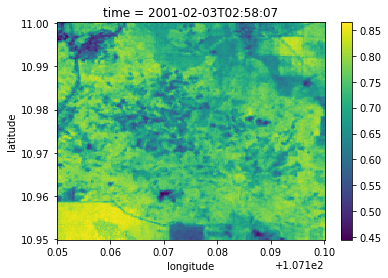

In [14]:
ndvi = NDVI(dataset_in)
ndvi.isel(time=0).plot()